# Lựa chọn đặc trưng and LASSO

Trong notebook này, chúng ta sẽ sử dụng LASSO để lựa chọn đặc trưng, xây dựng solver đã triển khai trước cho LASSO (trong sklearn). Cụ thể, chúng ta sẽ:  
* Chạy LASSO với các L1 penalty khác nhau.
* Chọn L1 penalty tốt nhất sử dụng tập kiểm định.
* Chọn L1 penalty tốt nhất sử dụng tập kiểm định với ràng buộc bổ sung về kích thước tập con. 

Trong bài tập tiếp theo, chúng ta sẽ tạo LASSO solver sử dụng coordinate descent.

## Thư viện

In [63]:
import sklearn
import pandas
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Load tập dữ liệu doanh số bán nhà

Tập dữ liệu từ doanh số bán nhà quận King, Seatle, WA.

In [64]:
full_data = pandas.read_csv("house_data/kc_house_data.csv", index_col=0)

## Tạo các đặc trung mới

Như ở lab 2 (*Lab-2.ipynb*), chúng ta sẽ xem xét các đặc trưng có các biến đổi đầu vào.

In [65]:
from math import log, sqrt
full_data['sqft_living_sqrt'] = full_data['sqft_living'].map(sqrt)
full_data['sqft_lot_sqrt'] = full_data['sqft_lot'].map(sqrt)
full_data['bedrooms_square'] = full_data['bedrooms'] ** 2

# Trong tập dữ liệu, 'floors' được xác định là type string, 
# nên chúng ta sẽ chuyển chúng thành float trước khi tạo đặc trưng mới. 
full_data['floors'] = full_data['floors'].astype(float) 
full_data['floors_square'] = full_data['floors'] ** 2

* Bình phương bedrooms sẽ tăng phân tách giữa ít phòng ngủ (chẳng hạn 1) và nhiều phòng ngủ (chẳng hạn 4) vì 1^2 = 1 còn 4^2 = 16. Do đó, biến này sẽ ảnh hưởng lớn tới các ngôi nhà có nhiều phòng ngủ.
* Mặt khác, căn bậc hai của sqft_living sẽ giảm phân tách giữa nhà lớn và nhà nhỏ. Chủ ngôi nhà cũng sẽ không vui hơn nếu nhà rộng gấp đôi.

# Tìm hiểu trọng số hồi quy với L1 penalty

Hãy khớp mô hình với tất cả đặc trưng hiện có cộng với các đặc trưng vừa tạo.

In [66]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Áp dụng L1 penalty cần thêm tham số (`alpha=l1_penalty`) cho mô hình  `Lasso` của Sklearn. (Các công cụ khác cũng phân tách các triển khai của LASSO). Khá giống Hồi quy Ridge/L2, các đặc trưng cũng cần được co giãn để đảm bảo đồng đều ở giữa.

In [67]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
l1_penalty=5e4
full_features = scaler.fit_transform(full_data[all_features].values)
full_labels = full_data['price'].values
model = Lasso(alpha=l1_penalty).fit(full_features, full_labels)
model.coef_

array([     0.        ,      0.        ,      0.        , 132571.09360631,
            0.        ,     -0.        ,     -0.        ,      0.        ,
            0.        ,  14623.33961421,  29004.06421249,      0.        ,
        90207.54789031,      0.        ,      0.        , -10722.34912003,
            0.        ])

Tìm các đặc trưng có trọng số khác 0.

In [68]:
# Bạn có biết numpy cũng có boolean selector tích hợp sẵn?
# find features with non-zero coefficients
feature_non_zero_coef = np.array(all_features)[model.coef_ != 0]
feature_non_zero_coef

array(['sqft_living', 'waterfront', 'view', 'grade', 'yr_built'],
      dtype='<U16')

Lưu ý rằng phần lớn trọng số được đặt thành 0. Vì vậy, bằng cách đặt L1 penalty đủ lớn, chúng ta có thể thực hiện lựa chọn tập con.

***QUIZ***:
Theo list các trọng số này, những đặc trưng nào đã được chọn?

>> Answer: 'sqft_living', 'waterfront', 'view', 'grade', 'yr_built'

# Lựa chọn L1 penalty

Để tìm một L1 penalty tốt, chúng ta sẽ khám phá nhiều giá trị sử dụng tập kiểm định. Hãy chia dữ liệu thành tập huấn luyện, tập kiểm định và tập kiểm tra:
* Chia dữ liệu bán hàng thành 2 tập: tập huấn luyện và tập kiểm tra (9/1)
* Chia tiếp tập huấn luyện thành 2 tập: tập huấn luyện và kiểm định (5/5)

Hãy dùng seed = 1 để có cùng kết quả!

In [69]:
from sklearn.model_selection import train_test_split
training_validation_set, test_set = train_test_split(full_data, test_size=0.1, random_state=1)
training_set, validation_set = train_test_split(training_validation_set, test_size=0.5, random_state=1)

# Preprocessing
scaler = StandardScaler()
training_features = scaler.fit_transform(training_set[all_features].values)
training_labels = training_set['price'].values

validation_features = scaler.transform(validation_set[all_features].values)
validation_labels = validation_set['price'].values

test_features = scaler.transform(test_set[all_features].values)
test_labels = test_set['price'].values

Tiếp theo, chúng ta sẽ viết một vòng lặp như sau: 
* Với `l1_penalty` trong phạm vi 21 bước giữa [1, 10^9] (sử dụng `np.logspace(0, 9, num=21)`.)
    * Khớp mô hình hồi quy với `l1_penalty` trong dữ liệu HUẤN LUYỆN. Chỉ định `alpha=l1_penalty` trong tham số.
    * Tính RSS trên dữ liệu KIỂM ĐỊNH (sử dụng `.predict()`) cho `l1_penalty`
* Báo lại `l1_penalty` nào cho RSS thấp nhất trong dữ liệu KIỂM ĐỊNH.

In [70]:
l1_penalties = np.logspace(1, 9, num=21)
rss_history = []
for penalty in l1_penalties:
    model = Lasso(alpha=penalty, max_iter=1000).fit(training_features, training_labels)
    predicted_labels = model.predict(validation_features)
    residuals = predicted_labels - validation_labels
    rss = sum(residuals ** 2)
    rss_history.append((penalty, rss))
    print("Penalty: {:.4E}, RSS: {:.4E}".format(penalty, rss))

Penalty: 1.0000E+01, RSS: 4.1658E+14
Penalty: 2.5119E+01, RSS: 4.1653E+14
Penalty: 6.3096E+01, RSS: 4.1643E+14
Penalty: 1.5849E+02, RSS: 4.1620E+14
Penalty: 3.9811E+02, RSS: 4.1589E+14
Penalty: 1.0000E+03, RSS: 4.1613E+14
Penalty: 2.5119E+03, RSS: 4.2208E+14
Penalty: 6.3096E+03, RSS: 4.5204E+14
Penalty: 1.5849E+04, RSS: 4.7423E+14
Penalty: 3.9811E+04, RSS: 5.3696E+14
Penalty: 1.0000E+05, RSS: 7.1444E+14
Penalty: 2.5119E+05, RSS: 1.2678E+15
Penalty: 6.3096E+05, RSS: 1.2908E+15
Penalty: 1.5849E+06, RSS: 1.2908E+15
Penalty: 3.9811E+06, RSS: 1.2908E+15
Penalty: 1.0000E+07, RSS: 1.2908E+15
Penalty: 2.5119E+07, RSS: 1.2908E+15
Penalty: 6.3096E+07, RSS: 1.2908E+15
Penalty: 1.5849E+08, RSS: 1.2908E+15
Penalty: 3.9811E+08, RSS: 1.2908E+15
Penalty: 1.0000E+09, RSS: 1.2908E+15


***QUIZ:*** Giá trị tốt nhất cho `l1_penalty` là bao nhiêu?

>> Answer: `398.1071705534973`

In [71]:
# Qua quan sát hay tính toán?
rss_history = np.array(rss_history)
# get the best penalty
best_penalty = rss_history[np.argmin(rss_history[:, 1]), 0]
best_penalty

398.1071705534973

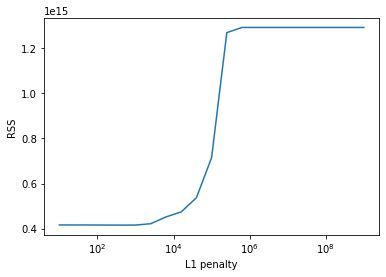

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(rss_history[:, 0], rss_history[:, 1])
plt.xlabel("L1 penalty")
plt.ylabel("RSS")
plt.xscale("log")

***QUIZ***
Với giá trị L1 penalty này, chúng ta có bao nhiêu trọng số khác 0?

In [73]:
best_model = Lasso(alpha=best_penalty).fit(training_features, training_labels)
best_model.coef_

array([ -14604.7810793 ,    5996.77426882,   41982.46766504,
        400236.96775414, -418706.9953942 ,   21561.84571615,
        -40443.99866935,  -24182.63588207,   35944.716302  ,
         42004.87192313,   29085.83803768,   17905.20224938,
        151197.38147356,  134957.93055994,   75159.46074802,
        -93901.43118032,    5847.89496613])

### Sử dụng GridSearchCV để tìm kiếm L1 penalty

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
training_set, test_set = train_test_split(full_data, test_size=0.1, random_state=1)
training_features = training_set[all_features].values
training_labels = training_set['price'].values

param_grid = {'model__alpha': l1_penalties}
lasso_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', Lasso())])
search = GridSearchCV(lasso_pipeline, 
                      param_grid, 
                      cv=10, 
                      scoring='neg_mean_squared_error')
search.fit(training_features, training_labels)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([1.00000000e+01, 2.51188643e+01, 6.30957344e+01, 1.58489319e+02,
       3.98107171e+02, 1.00000000e+03, 2.51188643e+03, 6.30957344e+03,
       1.58489319e+04, 3.98107171e+04, 1.00000000e+05, 2.51188643e+05,
       6.30957344e+05, 1.58489319e+06, 3.98107171e+06, 1.00000000e+07,
       2.51188643e+07, 6.30957344e+07, 1.58489319e+08, 3.98107171e+08,
       1.00000000e+09])},
             scoring='neg_mean_squared_error')

In [86]:
search.best_params_
best_model = search.best_estimator_.get_params()['model']
best_model.coef_

array([ -17191.33589533,    2559.9882924 ,   37018.55704411,
        462564.95711101, -325895.60938145,   16919.57331265,
        -34936.32634996,      -0.        ,   10777.27452021,
         45986.38902005,   32782.95276862,   16332.49594234,
        150194.3520997 ,       0.        ,     858.65236899,
        -93840.994991  ,    6342.19627209])

# Limit the number of nonzero weights Giới hạn số trọng số khác 0

Sẽ ra sao nếu chúng ta muốn giới hạn, 5 đặc trưng chẳng hạn? Điều này quan trọng nếu chúng ta muốn suy ra "quy tắc ngón tay cái" --- mô hình có thể diễn giải chỉ với một vài đặc trưng.

Trong phần này, chúng ta sẽ triển khai quy trình đơn giản gồm 2 giai đoạn :
1. Thăm dò phạm vi lớn các giá trị `l1_penalty` để tìm vùng các giá trị `l1_penalty` hẹp hơn mà mô hình chắc chắn sẽ có số lượng trọng số khác 0 mong muốn.
2. Thăm dò tiếp vùng hẹp đã thấy để tìm gái trị tốt cho `l1_penalty` đạt được độ thưa thớt mong muốn. Ở đây chúng ta sử dụng tập kiểm định để chọn giá trị tốt nhất cho `l1_penalty`. 

In [87]:
max_nonzeros = 5

## Khám phá phạm vi giá trị lớn hơn để tìm phạm vi hẹp với độ thưa thớt mong muốn

Hãy xác định một loạt các `l1_penalty_values` có thể:

In [88]:
l1_penalty_values = np.logspace(3, 5, num=21)
l1_penalty_values

array([  1000.        ,   1258.92541179,   1584.89319246,   1995.26231497,
         2511.88643151,   3162.27766017,   3981.07170553,   5011.87233627,
         6309.5734448 ,   7943.28234724,  10000.        ,  12589.25411794,
        15848.93192461,  19952.62314969,  25118.8643151 ,  31622.77660168,
        39810.71705535,  50118.72336273,  63095.73444802,  79432.82347243,
       100000.        ])

Giờ hãy triển khi vòng lặp tìm kiếm trong không gian có các giá trị `l1_penalty` có thể:

* Với `l1_penalty` trong `np.logspace(3, 5, num=21)`:
    * Khớp mô hình hồi quy với `l1_penalty` đã biết trong dữ liệu HUẤN LUYỆN. Chỉ định `alpha=l1_penalty` trong tham số.
    * Trích xuất trọng số của mô hình và đếm số trọng số khác 0. Lưu con số này vào một list. 
        * Gợi ý: `model.coef_` cho các tham số/hệ số đã tìm thấy (intercept) ở dạng mảng numpy. Sau đó có thể dùng array\[condition\] cho list các giá trị truyền điều kiện, hoặc chỉ dùng `np.count_nonzero()` có sẵn.

In [90]:
training_validation_set, test_set = train_test_split(full_data, test_size=0.1, random_state=1)
training_set, validation_set = train_test_split(training_validation_set, test_size=0.5, random_state=1)

# Preprocessing
scaler = StandardScaler()
training_features = scaler.fit_transform(training_set[all_features].values)
training_labels = training_set['price'].values

validation_features = scaler.transform(validation_set[all_features].values)
validation_labels = validation_set['price'].values

test_features = scaler.transform(test_set[all_features].values)
test_labels = test_set['price'].values

l1_penalties = np.logspace(3, 5, num=21)
num_of_nonzeros = [] # [(penalty, num_of_nonzeros)]

for penalty in l1_penalties:
    model = Lasso(alpha=penalty).fit(training_features, training_labels)
    num_of_nonzeros.append((penalty, np.count_nonzero(model.coef_)))
num_of_nonzeros

[(1000.0, 15),
 (1258.9254117941675, 15),
 (1584.893192461114, 15),
 (1995.2623149688789, 15),
 (2511.88643150958, 15),
 (3162.2776601683795, 14),
 (3981.0717055349733, 13),
 (5011.872336272725, 12),
 (6309.57344480193, 10),
 (7943.282347242814, 10),
 (10000.0, 10),
 (12589.254117941662, 10),
 (15848.93192461114, 6),
 (19952.62314968879, 6),
 (25118.864315095823, 5),
 (31622.776601683792, 5),
 (39810.71705534969, 5),
 (50118.72336272725, 5),
 (63095.7344480193, 3),
 (79432.82347242821, 3),
 (100000.0, 2)]

Trong phạm vi lớn này, chúng ta có thể tìm 2 đầu phạm vi hẹp mong muốn của `l1_penalty`. Ở một đầu, các giá trị `l1_penalty` có quá ít giá trị khác 0, còn đầu kia lại có quá nhiều giá trị khác 0.

Hãy tìm:
* `l1_penalty` nhỏ nhất có các số khác 0 bằng `max_nonzeros` (nếu chọn penalty nhỏ hơn giá trị này chắc chắn sẽ có rất nhiều trọng số khác 0).
    * Lưu giá trị này trong biến `l1_penalty_min` (sẽ sử dụng nó sau).
* `l1_penalty` lớn nhất có các số khác 0 bằng `max_nonzeros` (nếu chọn penalty lớn hơn giá trị này chắc chắn sẽ có rất ít trọng số khác 0).
    * Lưu giá trị này trong biến `l1_penalty_max` (sẽ sử dụng nó sau).


*Gợi ý: có nhiều cách để thực hiện, chẳng hạn:*
* Lập trình trong vòng lặp trên.
* Tạo một list với số lượng khác 0 cho từng giá trị `l1_penalty` và kiểm tra nó để tìm ranh giới thích hợp.

In [98]:
# l1 penalty values with 5 non-zero coefficients
penalty_five_nonzero = [x for x in num_of_nonzeros if x[1] == 5]
penalty_five_nonzero

[(25118.864315095823, 5),
 (31622.776601683792, 5),
 (39810.71705534969, 5),
 (50118.72336272725, 5)]

In [100]:
l1_penalty_min = np.min(penalty_five_nonzero, axis=0)[0]
l1_penalty_min

25118.864315095823

In [101]:
l1_penalty_max = np.max(penalty_five_nonzero, axis=0)[0]
l1_penalty_max

50118.72336272725

***QUIZ.*** Chúng ta tìm thấy các giá trị nào lần lượt cho `l1_penalty_min` và `l1_penalty_max`? 

>> Answer: <br>
>>`l1_penalty_min` = 25118.864315095823 <br>
>>`l1_penalty_max` = 50118.72336272725

## Khám phá phạm vi nhỏ các giá trị để tìm giải pháp với đúng số lượng các số khác 0 có RSS trong tập kiểm định nhỏ nhất

Chúng ta sẽ khám phá vùng hẹp các giá trị `l1_penalty` đã tìm thấy:

In [102]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* Với `l1_penalty` trong `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Khớp mô hình hồi quy với `l1_penalty` đã biết trong dữ liệu HUẤN LUYỆN. Chỉ định `alpha=l1_penalty`.
    * Đo lường RSS của mô hình đã tìm hiểu trong tập KIỂM ĐỊNH.

Tìm mô hình có RSS nhỏ nhất trong tập KIỂM ĐỊNH và độ thưa thớt *bằng*  `max_nonzeros`.

In [109]:
rss_history = [] # [(penalty, rss, model.coef_)]
for penalty in l1_penalty_values:
    model = Lasso(alpha=penalty).fit(training_features, training_labels)
    predicted_validation = model.predict(validation_features)
    rss = sum((predicted_validation - validation_labels) ** 2)
    rss_history.append((penalty, rss, model.coef_))

In [112]:
for history in rss_history:
    print("Penalty: {:.4E}, RSS: {:.4E}".format(history[0], history[1]))

Penalty: 2.5119E+04, RSS: 4.9432E+14
Penalty: 2.6435E+04, RSS: 4.9743E+14
Penalty: 2.7750E+04, RSS: 5.0069E+14
Penalty: 2.9066E+04, RSS: 5.0408E+14
Penalty: 3.0382E+04, RSS: 5.0761E+14
Penalty: 3.1698E+04, RSS: 5.1128E+14
Penalty: 3.3014E+04, RSS: 5.1509E+14
Penalty: 3.4329E+04, RSS: 5.1903E+14
Penalty: 3.5645E+04, RSS: 5.2312E+14
Penalty: 3.6961E+04, RSS: 5.2734E+14
Penalty: 3.8277E+04, RSS: 5.3170E+14
Penalty: 3.9592E+04, RSS: 5.3620E+14
Penalty: 4.0908E+04, RSS: 5.4084E+14
Penalty: 4.2224E+04, RSS: 5.4562E+14
Penalty: 4.3540E+04, RSS: 5.5054E+14
Penalty: 4.4856E+04, RSS: 5.5559E+14
Penalty: 4.6171E+04, RSS: 5.6079E+14
Penalty: 4.7487E+04, RSS: 5.6612E+14
Penalty: 4.8803E+04, RSS: 5.7159E+14
Penalty: 5.0119E+04, RSS: 5.7720E+14


In [113]:
# Get min rss in rss_history
min_rss_history = min(rss_history, key=lambda x: x[1])
min_rss_history

(25118.864315095823,
 494318243857056.4,
 array([    -0.        ,      0.        ,      0.        , 143559.23704386,
             0.        ,     -0.        ,     -0.        ,      0.        ,
             0.        ,  26144.47317615,  31316.2925758 ,      0.        ,
        121438.23477256,      0.        ,      0.        , -53125.49162964,
             0.        ]))

***QUIZ***
1. Giá trị của `l1_penalty` trong phạm vi hẹp hơn có RSS thấp nhất trong tập KIỂM ĐỊNH và độ thưa *bằng* `max_nonzeros` là?
   >> Answer: 25118.864315095823<br>
2. Các đặc trung nào trong mô hình này có các hệ số khác 0?

In [114]:
np.array(all_features)[min_rss_history[2] != 0]

array(['sqft_living', 'waterfront', 'view', 'grade', 'yr_built'],
      dtype='<U16')